In [33]:
import datetime
import calendar

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

#from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

from sklearn.utils import resample

import seaborn as sns

%matplotlib inline

np.random.seed(0)
fmt = lambda x,pos: '{:.0%}'.format(x)

## We are going to follow the CRISP-DM process as outlined below.

### 1. Business understanding: 
Outline the questions you will answer along with why they are relevant and important
### 2. Data understanding: 
Provide some stats about your data like mean and std deviations of the different features
### 3. Data preparation: 
Show how you clean and prepare the data. It is important to document and not just write the code
### 4. Data modeling: 
If you created a model this is the section you would put it in or the analysis
### 5. Results evaluation: 
Conclusion and discussion

### 1.Business Understanding:

The below 5 questions is what we are going to try and answer for can we identify any trends in who misses the appointment

1. Which Gender predominatly missed the appointment? Is there any trend ? 
2. Is there day of the week having any impact on No-show ? 
3. Does the SMS reminder help reduce the No-show occurrence ?
4. Which Age group needs more appointments and what are they success rate in meeting the appointment ?
5. Gap between scheduled day and appointment day ?

### 2. Data Understanding:

In [34]:
# Collect Initial Data
df = pd.read_csv('./KaggleV2-May-2016.csv')

df.shape

(110527, 14)

In [35]:
# Sample & Explore Data
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [36]:
# Describe Data
# Lets now infer the basic information of the dataframe and see what columns might be useful
df.info()

# based on the data - Initial findings / questions that come up are as follows
# There seems to be no NaN data. This total rows in the dataset is 110,527 and all columns have the same number of values.
# We do have two dates - One the day when the appointment was scheduled and the day when the actual appointment was.
# Probably we can derive some additional features from these dates to see how far back the appointment was made? Does it have any weight on missing the appointment ?
# We also have few categorical values - which we might need to do One-Hot encoding so that we have each unique value in the category represented in a binary format. Also we need only N-1 unique values to be represented in One-Hot encoding so we will be removing the excess dummy value.
# We do have Age. We can classify the Age into multiple groups to understand which Age group honors more the appointment and which doesn't. Like if the appointment is for kids, do they make it or if it was for senior people do they make it ?

# Lets start exploring and try and find answers to these intriguing questions.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [37]:
#Verify Data Quality for NaN
#Looks like there are no missing values

df.dropna(how="any").shape

(110527, 14)

### 3. Data Preparation & Inferential Analysis

For all the business questions that we plan to answer, there are few features that are not currently existing in the dataset. Like for "Age group"wise No-show trend, there is no "Age group" column in the dataset. 

So in this data preparation stage, we will ensure that we have all the data that we need in the right format for our modeling and data analytics.

Below are the data preparation steps towards this.

Existing columns that we need for our analysis are

1. We will use all these columns directly for our analysis:
   *  Gender            
   *  Neighbourhood     
   *  SMS_received      
   *  No-show           

2. We will create new features out of these columns. These as such doesnt add value for the analysis that we are trying to do.
   *  ScheduledDay      
   *  AppointmentDay    
   *  Age               

3. We are not performing any analysis on the below features but if someone wants to perform, pls feel free to use them.
   *  Scholarship       
   *  Hipertension      
   *  Diabetes          
   *  Alcoholism        
   *  Handcap           

### Insight 1: Analyze if Gender has an Impact on No-show

In [38]:
# Analysis 1.1
# A simple crosstab of Gender vs No-show 

pd.crosstab(df.Gender, df['No-show'], margins=True, margins_name="Total")

No-show,No,Yes,Total
Gender,,,
F,57246,14594,71840
M,30962,7725,38687
Total,88208,22319,110527


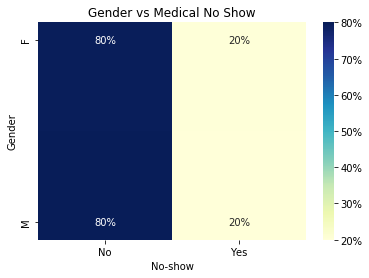

In [39]:
# Analysis 1.2
# Crosstab between Gender vs No-show normalized to percentages to identify its impact. 
# We then use Seaborn heatmap to visually see the output.


ax = sns.heatmap(pd.crosstab(df.Gender, df['No-show'], normalize='index'),
            cmap="YlGnBu", annot=True,  cbar=True, fmt='.0%',
            cbar_kws={'format': FuncFormatter(fmt)});
bottom, top = ax.get_ylim()
ax.set_title("Gender vs Medical No Show")
ax.set_ylim(bottom + 0.1, top - 0.1);
ax.get_figure().savefig('./gender_noshow.png')

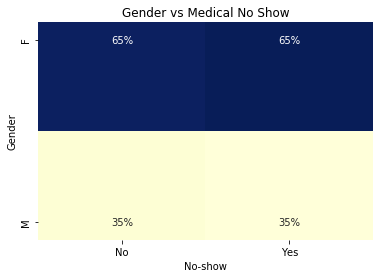

In [40]:
# Analysis 1.3
# Crosstab between Gender vs No-show normalized to percentages to identify its impact. 
# We then use Seaborn heatmap to visually see the output.

ax = sns.heatmap(pd.crosstab(df.Gender, df['No-show'], normalize='columns'),
            cmap="YlGnBu", annot=True,  cbar=False, fmt='.0%',
            cbar_kws={'format': FuncFormatter(fmt)});
bottom, top = ax.get_ylim()
ax.set_title("Gender vs Medical No Show")
ax.set_ylim(bottom + 0.1, top - 0.1);
ax.get_figure().savefig('./gender_appoints_booked.png')

### Inference 1:

1. Gender doesnt seem to play a major role in missing the appointment. (Analysis 1.2)
2. Both Male and Female appointees missed by 20% of the time. (Analysis 1.2)
3. Females took 30% more appointments than Male. (Analysis 1.3)

### Insight 2: Is there any interesting trends or patterns for Appointments with respect to the 'Days of the week' ?

In [41]:
# To do this analysis, we need to first get the weekday of the appointment. We can do this by writing a helper lamba function

#1. Create two new columns for populating the weekday_number and 'day of the week' of the appointment day. 
# Its a numeric value - 0 to 6 representing Monday to Sunday.

wd_num = lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%SZ").date().weekday()
wd = lambda x: calendar.day_name[x]
df['weekday_num'] = df['AppointmentDay'].apply(wd_num)
df['weekday'] = df['weekday_num'].apply(wd)

df.tail()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,weekday_num,weekday
110522,2.572134e+12,5651768,F,2016-05-03T09:15:35Z,2016-06-07T00:00:00Z,56,MARIA ORTIZ,0,0,0,0,0,1,No,1,Tuesday
110523,3.596266e+12,5650093,F,2016-05-03T07:27:33Z,2016-06-07T00:00:00Z,51,MARIA ORTIZ,0,0,0,0,0,1,No,1,Tuesday
110524,1.557663e+13,5630692,F,2016-04-27T16:03:52Z,2016-06-07T00:00:00Z,21,MARIA ORTIZ,0,0,0,0,0,1,No,1,Tuesday
110525,9.213493e+13,5630323,F,2016-04-27T15:09:23Z,2016-06-07T00:00:00Z,38,MARIA ORTIZ,0,0,0,0,0,1,No,1,Tuesday
110526,3.775115e+14,5629448,F,2016-04-27T13:30:56Z,2016-06-07T00:00:00Z,54,MARIA ORTIZ,0,0,0,0,0,1,No,1,Tuesday


In [42]:
# Analysis 2.1
#Crosstab between weekday and total appointments and No-show details

pd.crosstab([df.weekday_num, df.weekday], df['No-show'],rownames=["Weekday#","Day of the Week"], colnames=["No Show"], margins=True, margins_name="Total")

,No Show,No,Yes,Total
Weekday#,Day of the Week,,,
0,Monday,18025,4690,22715
1,Tuesday,20488,5152,25640
2,Wednesday,20774,5093,25867
3,Thursday,13909,3338,17247
4,Friday,14982,4037,19019
5,Saturday,30,9,39
Total,,88208,22319,110527


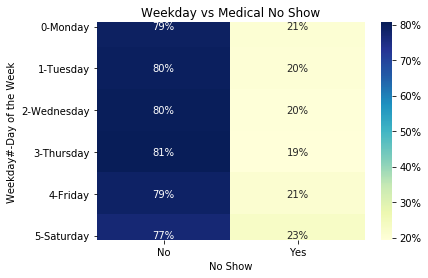

In [43]:
# Analysis 2.2
# Crosstab between Weekday vs No-show normalized to percentages to identify its impact. 
# We then use Seaborn heatmap to visually see the output.

ax = sns.heatmap(pd.crosstab([df.weekday_num, df.weekday], df['No-show'],rownames=["Weekday#","Day of the Week"], colnames=["No Show"], normalize='index'),
            cmap="YlGnBu", annot=True,  cbar=True, fmt='.0%',
            cbar_kws={'format': FuncFormatter(fmt)});
bottom, top = ax.get_ylim()
ax.set_title("Weekday vs Medical No Show")
ax.set_ylim(bottom + 0.1, top - 0.1);
ax.get_figure().savefig('./weekday_noshow.png',pad_inches=0.3)

### Inference 2:

1. The Medical clinic seems to work only from Monday to Friday with probably emergency cases seen on Saturday. Hence the Saturday count is way too less. Sunday is a holiday. (Analysis 2.1)
2. Tuesday and Wednesday seems to be the busy days for the clinic followed by Monday, Friday & Thursday respectively.(Analysis 2.1)
3. The day of the week doesn't have any impact on the No-Show of the appointments. (Analysis 2.2)

### Insight 3: Did the SMS Reminders help reduce the No-Show for the patients or any groups in particular ?

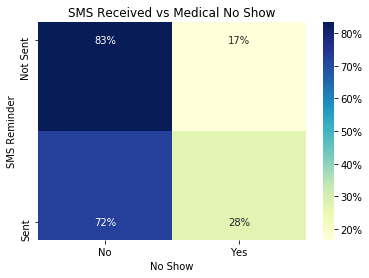

In [44]:
# Analysis 3.1
# Crosstab between SMS vs No-show normalized to percentages to identify its impact. 

# Lets find out how many number of days before they booked the appointment. 
# And lets see if there is any trend in these bookings being missed / SMS helping not to miss the appointments

df['SMS_Desc'] = df['SMS_received'].apply(lambda x: 'Sent' if x == 1 \
                                                                   else 'Not Sent')

ax = sns.heatmap(pd.crosstab([df.SMS_Desc], df['No-show'],rownames=["SMS Reminder"], colnames=["No Show"],  normalize='index'),
            cmap="YlGnBu", annot=True,  cbar=True, fmt='.0%',
            cbar_kws={'format': FuncFormatter(fmt)});
bottom, top = ax.get_ylim()
ax.set_title("SMS Received vs Medical No Show")
ax.set_ylim(bottom + 0.1, top - 0.1);
ax.get_figure().savefig('./sms_received_noshow.png')

### Inference 3:
1. We do find an interesting observation that SMS Reminders have actually NOT helped in reducing the No-Show but rather increased its occurrence.
2. When compared, there are 28% of No-Show SMS received patients to 17% of No-Show who never received any reminder of their appointments

### Insight 4: Does Booking in Advance or Age group has any trend with missing the appointments ?

In [45]:
# Before we do this, lets add a couple of new features that might come in handy

#1. Lets also group the patients based on Age into 6 broad categories and see if any of these groups had any impact
#   Baby               -> 0 - 3
#   Kid                -> 4  - 12
#   Adolescent         -> 13 - 19
#   Young_Adult        -> 20 - 39
#   Adult              -> 40 - 64
#   Senior             -> 65 & Above

In [46]:
# Lets do a quick summary of value counts for each Age. We see that there is 1 record with Age = -1. 
# We will consider this age row also as a Baby for our analysis.
df.Age.value_counts()

 0      3539
 1      2273
 52     1746
 49     1652
 53     1651
        ... 
 115       5
 100       4
 102       2
 99        1
-1         1
Name: Age, Length: 104, dtype: int64

In [47]:
def create_age_groups(Age):
    """
    This function creates a new feature to the input dataframe based on the Age.
    
    It creates categorical values based on Age. It categorizes the Age into 1 of the 6 categories.
    #   Baby               -> 0 - 3
    #   Kid                -> 4  - 12
    #   Adolescent         -> 13 - 19
    #   Young_Adult        -> 20 - 39
    #   Adult              -> 40 - 64
    #   Senior             -> 65 & Above
    
    INPUT:
    col - Age column
    
    OUTPUT:
    Age_Group
    
    """
    if Age >= 65:
        Age_Group = 'Senior'
    elif Age >= 40:
        Age_Group = 'Adult'
    elif Age >= 20:
        Age_Group = 'Young_Adult'
    elif Age >= 13:
        Age_Group = 'Adolescent'
    elif Age >= 4:
        Age_Group = 'Kid'   
    else:
        Age_Group = 'Baby'         
    
    return Age_Group

df['Age_Group'] = df['Age'].apply(create_age_groups)
df.tail()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,weekday_num,weekday,SMS_Desc,Age_Group
110522,2.572134e+12,5651768,F,2016-05-03T09:15:35Z,2016-06-07T00:00:00Z,56,MARIA ORTIZ,0,0,0,0,0,1,No,1,Tuesday,Sent,Adult
110523,3.596266e+12,5650093,F,2016-05-03T07:27:33Z,2016-06-07T00:00:00Z,51,MARIA ORTIZ,0,0,0,0,0,1,No,1,Tuesday,Sent,Adult
110524,1.557663e+13,5630692,F,2016-04-27T16:03:52Z,2016-06-07T00:00:00Z,21,MARIA ORTIZ,0,0,0,0,0,1,No,1,Tuesday,Sent,Young_Adult
110525,9.213493e+13,5630323,F,2016-04-27T15:09:23Z,2016-06-07T00:00:00Z,38,MARIA ORTIZ,0,0,0,0,0,1,No,1,Tuesday,Sent,Young_Adult
110526,3.775115e+14,5629448,F,2016-04-27T13:30:56Z,2016-06-07T00:00:00Z,54,MARIA ORTIZ,0,0,0,0,0,1,No,1,Tuesday,Sent,Adult


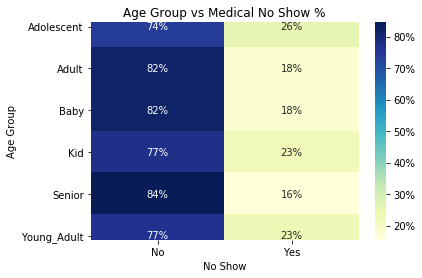

In [48]:
# Analysis 4.1
# Crosstab between Age_Group vs No-show normalized to percentages to identify its impact. 
# We then use Seaborn heatmap to visually see the output.

ax = sns.heatmap(pd.crosstab([df.Age_Group], df['No-show'],rownames=["Age Group"], colnames=["No Show"], normalize='index'),
            cmap="YlGnBu", annot=True,  cbar=True, fmt='.0%',
            cbar_kws={'format': FuncFormatter(fmt)});
bottom, top = ax.get_ylim()
ax.set_title("Age Group vs Medical No Show %")
ax.set_ylim(bottom + 0.1, top - 0.1);
ax.get_figure().savefig('./age_group_noshow_percent.png');

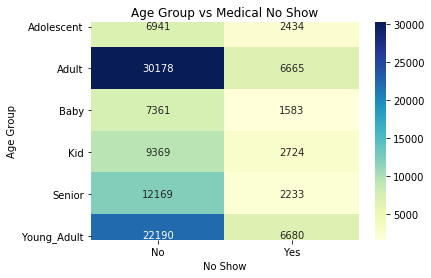

In [49]:
# Analysis 4.2
# Crosstab between Age_Group vs No-show normalized to percentages to identify its impact. 
# We then use Seaborn heatmap to visually see the output.

ax = sns.heatmap(pd.crosstab([df.Age_Group], df['No-show'],rownames=["Age Group"], colnames=["No Show"]),
            cmap="YlGnBu", annot=True,  cbar=True, fmt='4.0f');
bottom, top = ax.get_ylim()
ax.set_title("Age Group vs Medical No Show")
ax.set_ylim(bottom + 0.1, top - 0.1);
ax.get_figure().savefig('./age_group_noshow.png');

In [50]:
#2. Lets create a new feature for number of days in advance a booking was made. If it is zero, it is same day appointment

dt = lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%SZ").date()  #"%Y-%m-%dT%H:%M:%SZ"
df['AdvanceDays'] = (df['AppointmentDay'].apply(dt) - df['ScheduledDay'].apply(dt)).dt.days

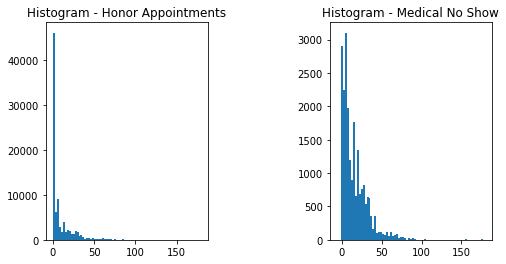

In [51]:
# Before we deep dive into AdvanceDays booking, lets see how that correlates to No-Show. 
fig, ax = plt.subplots(1, 2,figsize=(8,4))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.75, hspace=None)
# The parameter meanings (and suggested defaults) are:

# left  = 0.125  # the left side of the subplots of the figure
# right = 0.9    # the right side of the subplots of the figure
# bottom = 0.1   # the bottom of the subplots of the figure
# top = 0.9      # the top of the subplots of the figure
# wspace = 0.2   # the amount of width reserved for blank space between subplots
# hspace = 0.2   # the amount of height reserved for white space between subplots

ax = ax.ravel()
ax[0].hist(df[df['No-show']=='No']['AdvanceDays'], bins=75)
ax[1].hist(df[df['No-show']=='Yes']['AdvanceDays'], bins=75);
#bottom, top = ax.get_ylim()
ax[0].set_title("Histogram - Honor Appointments")
ax[1].set_title("Histogram - Medical No Show");

# We see that the number of appointments booked for various advance booking are not same. 
# Also the No-show fluctuates across these days. 
# Hence lets create custom bins for the booking days and then see if we are able to see any pattern
plt.savefig('./adv_booking_hist.png')

In [52]:
#3. Create advance_days_bin for grouping the booked in advance days into logical buckets
def create_advance_days_bins(advance_days):
    """
        This function creates a new feature to the input dataframe based on the AdvanceDays.

        It creates categorical values based on AdvanceDays. It categorizes the Age into 1 of the 10 categories.
        #   90-Days+               -> More than or equal to 90 days in advance
        #   30-Days+               -> More than or equal to 30 days in advance
        #   7-Days+                -> More than or equal to 7 days in advance
        #   6-Days                 -> 6 days in advance
        #   5-Days                 -> 5 days in advance
        #   4-Days                 -> 4 days in advance
        #   3-Days                 -> 3 days in advance
        #   2-Days                 -> 2 days in advance
        #   1-Days                 -> 1 days in advance
        #   0-Days                 -> Same day

        INPUT:
        advance_days - Number of days in advance an appointment is booked

        OUTPUT:
        adv_bin - AdvanceDays Bin

    """
    
    if advance_days >= 90:
        adv_bin = '90-Days+'
    elif advance_days >= 30:
        adv_bin = '30-Days+'             
    elif advance_days >= 7:
        adv_bin = '07-Days+'
    elif advance_days == 6:
        adv_bin = '06-Days'
    elif advance_days == 5:
        adv_bin = '05-Days'
    elif advance_days == 4:
        adv_bin = '04-Days'
    elif advance_days == 3:
        adv_bin = '03-Days'
    elif advance_days == 2:
        adv_bin = '02-Days'
    elif advance_days == 1:
        adv_bin = '01-Day'
    else:
        adv_bin = '00-SameDay'        
    return adv_bin

df['adv_bin'] = df['AdvanceDays'].apply(create_advance_days_bins)

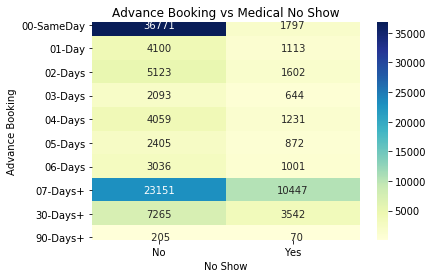

In [53]:
# Analysis 4.3
# Crosstab between AdvanceBin vs No-show normalized to percentages to identify its impact. 
# We then use Seaborn heatmap to visually see the output.

ax = sns.heatmap(pd.crosstab([df.adv_bin], df['No-show'],rownames=["Advance Booking"], colnames=["No Show"]),
            cmap="YlGnBu", annot=True,  cbar=True, fmt='4.0f');
bottom, top = ax.get_ylim()
ax.set_title("Advance Booking vs Medical No Show")
ax.set_ylim(bottom + 0.1, top - 0.1);
ax.get_figure().savefig('./advance_bookins_noshow.png');

### Inference 4:
1. Adolescents missed their appointments by 26% followed by Kids (23%) and Young Adults (23%). These are the top 3 No-show based on percentages (Analysis 4.1)
2. In terms of pure absolute number of appointments missed, Young Adults & Adults take the spot with 6600+ No-shows each (Analysis 4.2)
3. Majority of the patients for the clinic were Adults (30K) followed by Young Adults (22K) and then the Seniors (12K) (Analysis 4.2)
4. In terms of missed appointments, the same day appointments were the least interms of misses (~4%). Whereas the highest appointment misses happen when the booking was made more than 7 days. About 14K missed in 44K. Roughly 31.5%. (Analysis 4.3)

### 4. Modeling

I have created 3 classification models and used them for predicting if an appointment could be a show or No-show?
1. Can we predict No-Show / Show based on the data
   1. Logistic Regression
   2. Random Forest
   3. Naive Bayes Classification
2. Using techniques to rebalance imbalanced outputs so precision can be improved
   1. Undersampling
   2. Oversampling
   3. Synthetic Sample
   
####  Model Prediction
#####  Can we predict if a new patient will Show or No-Show ?
For this question, we will do the following by doing the following

1. Identify all unnecessary columns in the Dataframe that are not required or add any value to the findings. Remove them.
2. Identify all categorical columns and convert them using One-Hot encoding with dropFirst = True
3. Separate the Dataframe into X input and y output series.
4. Split into train and test
5. Apply model on train dataset
6. Test model using test dataset
7. Measure the score of accuracy   

In [54]:
def model_fit_predict(model, X_train, y_train, X_test, y_test, target_names, model_name):
    #5. Apply model on train dataset
    model.fit(X_train, y_train)

    #6. Test model using test dataset
    y_pred = model.predict(X_test)

    #7. Measure the score of accuracy
    print('{1} Evaluation...Accuracy Score = {0:3.2f}'.format(accuracy_score(y_test, y_pred), model_name))

    #8. Confusion Matrix of the prediction
    print(confusion_matrix(y_test, y_pred ))

    #9. Classification Report of the prediction
    print(classification_report(y_test, y_pred,target_names=target_names))    
    return y_pred

def logistic_regression(X_train, y_train, X_test, y_test, target_names, model_name):
    # Logistics Regression Model
    reg_lr = LogisticRegression(random_state = 0)    
    y_pred_lr = model_fit_predict(reg_lr, X_train, y_train, X_test, y_test, target_names, model_name)
    return y_pred_lr

def random_forest_classifier(X_train, y_train, X_test, y_test, target_names, model_name):
    # Random Forest Classification Model
    clf_rfc = RandomForestClassifier(random_state = 0, n_estimators=10)
    y_pred_rfc = model_fit_predict(clf_rfc, X_train, y_train, X_test, y_test, target_names, model_name)
    return y_pred_rfc

def naive_bayes_classifier(X_train, y_train, X_test, y_test, target_names, model_name):
    # Naive Bayes Gaussian Model
    #5. Apply model on train dataset
    clf_nb = GaussianNB()
    y_pred_nb = model_fit_predict(clf_nb, X_train, y_train, X_test, y_test, target_names, model_name)
    return y_pred_nb

def run_all_models(X_train, y_train, X_test, y_test, target_names):
    #5. Model Creation and Validation
    y_pred_lr  = logistic_regression(X_train, y_train, X_test, y_test, target_names, 'Logistic Regression')
    y_pred_rfc = random_forest_classifier(X_train, y_train, X_test, y_test, target_names,'Random Forest')
    y_pred_nb  = naive_bayes_classifier(X_train, y_train, X_test, y_test, target_names,'Naive Bayes')
    
# Lets create the Model
#df = df_bkup
#df_bkup = df
#1. Identify all unnecessary columns in the Dataframe that are not required or add any value to the findings. Remove them.
df = df.drop(columns=['PatientId','AppointmentID','ScheduledDay','AppointmentDay','Age','weekday','SMS_Desc','AdvanceDays'])

#2. Identify all categorical columns and convert them using One-Hot encoding with dropFirst = True
df = pd.get_dummies(df, columns = ['Gender','Neighbourhood','Age_Group','adv_bin','No-show'], drop_first=True)

#3. Separate the Dataframe into X input and y output series.
X = df.drop(['No-show_Yes'], axis=1)
y = df['No-show_Yes']
target_names = ['Show', 'No-Show']

#4. Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.3)

#5. Model Execution
run_all_models(X_train, y_train, X_test, y_test, target_names)

C:\Users\kamin_000\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic Regression Evaluation...Accuracy Score = 0.80
[[26510    61]
 [ 6536    52]]
              precision    recall  f1-score   support

        Show       0.80      1.00      0.89     26571
     No-Show       0.46      0.01      0.02      6588

    accuracy                           0.80     33159
   macro avg       0.63      0.50      0.45     33159
weighted avg       0.73      0.80      0.72     33159

Random Forest Evaluation...Accuracy Score = 0.77
[[24080  2491]
 [ 5134  1454]]
              precision    recall  f1-score   support

        Show       0.82      0.91      0.86     26571
     No-Show       0.37      0.22      0.28      6588

    accuracy                           0.77     33159
   macro avg       0.60      0.56      0.57     33159
weighted avg       0.73      0.77      0.75     33159

Naive Bayes Evaluation...Accuracy Score = 0.34
[[ 5570 21001]
 [  964  5624]]
              precision    recall  f1-score   support

        Show       0.85      0.21      0.34    

In [58]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


#6. Resample - Undersampling
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.3)

df_train = pd.concat((X_train, pd.DataFrame(y_train.T)),axis=1)
undersample_size = y_train.value_counts().min()
# Display new class counts
print (y_train.value_counts())

df_train_major = df_train[df_train['No-show_Yes']==0]
df_train_minor = df_train[df_train['No-show_Yes']==1]

df_train_major_undersample = resample(df_train_major, 
                                 replace=True,     
                                 n_samples=undersample_size,    
                                 random_state=0) 
df_train = pd.concat([df_train_major_undersample, df_train_minor], axis = 0)
X_train = df_train.drop(columns = ['No-show_Yes'])
y_train = df_train['No-show_Yes']
 
# Display new class counts
print (y_train.value_counts())

#5. Model Execution
run_all_models(X_train, y_train, X_test, y_test, target_names)


0    61637
1    15731
Name: No-show_Yes, dtype: int64
1    15731
0    15731
Name: No-show_Yes, dtype: int64


C:\Users\kamin_000\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic Regression Evaluation...Accuracy Score = 0.58
[[13889 12682]
 [ 1239  5349]]
              precision    recall  f1-score   support

        Show       0.92      0.52      0.67     26571
     No-Show       0.30      0.81      0.43      6588

    accuracy                           0.58     33159
   macro avg       0.61      0.67      0.55     33159
weighted avg       0.79      0.58      0.62     33159

Random Forest Evaluation...Accuracy Score = 0.62
[[16153 10418]
 [ 2278  4310]]
              precision    recall  f1-score   support

        Show       0.88      0.61      0.72     26571
     No-Show       0.29      0.65      0.40      6588

    accuracy                           0.62     33159
   macro avg       0.58      0.63      0.56     33159
weighted avg       0.76      0.62      0.66     33159

Naive Bayes Evaluation...Accuracy Score = 0.51
[[12636 13935]
 [ 2303  4285]]
              precision    recall  f1-score   support

        Show       0.85      0.48      0.61    

In [56]:
#7. Resample - Oversampling
from sklearn.utils import resample
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.3)

df_train = pd.concat((X_train, pd.DataFrame(y_train.T)),axis=1)
oversample_size = y_train.value_counts().max()
# Display new class counts
print (y_train.value_counts())

df_train_major = df_train[df_train['No-show_Yes']==0]
df_train_minor = df_train[df_train['No-show_Yes']==1]

df_train_minor_oversample = resample(df_train_minor, 
                                 replace=True,     
                                 n_samples=oversample_size,    
                                 random_state=0) 
df_train = pd.concat([df_train_major, df_train_minor_oversample], axis = 0)
X_train = df_train.drop(columns = ['No-show_Yes'])
y_train = df_train['No-show_Yes']
 
# Display new class counts
print (y_train.value_counts())

#5. Model Execution
run_all_models(X_train, y_train, X_test, y_test, target_names)

0    61637
1    15731
Name: No-show_Yes, dtype: int64
1    61637
0    61637
Name: No-show_Yes, dtype: int64


C:\Users\kamin_000\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic Regression Evaluation...Accuracy Score = 0.58
[[13777 12794]
 [ 1243  5345]]
              precision    recall  f1-score   support

        Show       0.92      0.52      0.66     26571
     No-Show       0.29      0.81      0.43      6588

    accuracy                           0.58     33159
   macro avg       0.61      0.66      0.55     33159
weighted avg       0.79      0.58      0.62     33159

Random Forest Evaluation...Accuracy Score = 0.69
[[19708  6863]
 [ 3420  3168]]
              precision    recall  f1-score   support

        Show       0.85      0.74      0.79     26571
     No-Show       0.32      0.48      0.38      6588

    accuracy                           0.69     33159
   macro avg       0.58      0.61      0.59     33159
weighted avg       0.75      0.69      0.71     33159

Naive Bayes Evaluation...Accuracy Score = 0.29
[[ 3741 22830]
 [  694  5894]]
              precision    recall  f1-score   support

        Show       0.84      0.14      0.24    

In [57]:
#8. Resample - Synthetic sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.3)

#SMOTE
import sys
!{sys.executable} -m pip install imblearn
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=12)
# Display new class counts
print (y_train.value_counts())

X_train, y_train = sm.fit_sample(X_train, y_train)
# Display new class counts
print (np.bincount(y_train))

#print (Y_train.value_counts() , np.bincount(y_train_res))

#5. Model Execution
run_all_models(X_train, y_train, X_test, y_test, target_names)

0    61637
1    15731
Name: No-show_Yes, dtype: int64
[61637 61637]


C:\Users\kamin_000\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic Regression Evaluation...Accuracy Score = 0.69
[[19154  7417]
 [ 3012  3576]]
              precision    recall  f1-score   support

        Show       0.86      0.72      0.79     26571
     No-Show       0.33      0.54      0.41      6588

    accuracy                           0.69     33159
   macro avg       0.59      0.63      0.60     33159
weighted avg       0.76      0.69      0.71     33159

Random Forest Evaluation...Accuracy Score = 0.66
[[18520  8051]
 [ 3183  3405]]
              precision    recall  f1-score   support

        Show       0.85      0.70      0.77     26571
     No-Show       0.30      0.52      0.38      6588

    accuracy                           0.66     33159
   macro avg       0.58      0.61      0.57     33159
weighted avg       0.74      0.66      0.69     33159

Naive Bayes Evaluation...Accuracy Score = 0.32
[[ 5137 21434]
 [ 1221  5367]]
              precision    recall  f1-score   support

        Show       0.81      0.19      0.31    

### 5. Evaluation

We find that Logistic Regression performed better than any other model. Even if we were to try and balance data based on the output (major / minor) classification (in this case it is 80% of the appointments were NOT missed)  using 3 techniques such as Undersampling, Oversampling and Synthetic Sample, still the initial Logistic Regression model out performed interms of accuracy and precision.

#### Where to do from here next ?

If you are further interested on this dataset, you could also potentially look at answering the following questions.
1. Does medication conditions have any trend over No-show ?
2. Does scholarship have an impact on No-show ?
3. Which Neighborhoods have more No-show ?
4. Timeseries trend over Appointment days for No-show vs show ?
5. Is there any trend in how soon the appointments are made for these age groups ?